In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

/home/jonat/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [55]:
m1 = 1
m2 = 1
m3 = 1
m4 = 1
m5 = 5
m6 = 5
l1 = 1
l2 = 1
l3 = 1
l4 = 1
l5 = 0.1
g = 9.81

dt = 0.01
tf = 20
t = np.arange(0, tf, dt)

Q_0 = np.array([[0, 0], [0, 0], [2.1, 0], [2.1, 0], [1, 0], [1.1, 0]])
Q_dot_0 = np.array([[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

n = 6
k = lambda t: 5 if t < 10 else 4
M = np.diag([m1, m2, m3, m4, m5, m6]) # n x n
M_inv = np.linalg.inv(M) # n x n
G = np.array([[0, g], [0, g], [0, g], [0, g], [0, g], [0, g]]) # n x 2
D_of_G = lambda t: np.array([[ 1,  0,  0,  0,  0],
                                [ 0,  1,  0,  0,  0],
                                [ 0,  0,  1,  0,  0],
                                [ 0,  0,  0,  1,  0],
                                [-1, -1,  0,  0,  1],
                                [ 0,  0, -1, -1, -1]])[:n, :k(t)] # n x k

# Edge Control
k1 = 10
k2 = 10

theta_d = lambda t: np.pi/4*np.cos(np.pi/4*t)
theta_d_dot = lambda t: -np.pi**2/16*np.sin(np.pi/4*t)
theta_d_ddot = lambda t: -np.pi**3/64*np.cos(np.pi/4*t)
Qed = lambda t, k: np.array([[l1*np.cos(theta_d(t)), l1*np.sin(theta_d(t))],
                          [-l2*np.cos(theta_d(t)), l2*np.sin(theta_d(t))],
                          [-l3*np.cos(theta_d(t)), -l3*np.sin(theta_d(t))],
                          [l4*np.cos(theta_d(t)), -l4*np.sin(theta_d(t))],
                          [0, l5]])[:k, :]
Qed_dot = lambda t, k: np.array([[-l1*np.sin(theta_d(t))*theta_d_dot(t), l1*np.cos(theta_d(t))*theta_d_dot(t)],
                              [l2*np.sin(theta_d(t))*theta_d_dot(t), l2*np.cos(theta_d(t))*theta_d_dot(t)],
                              [l3*np.sin(theta_d(t))*theta_d_dot(t), -l3*np.cos(theta_d(t))*theta_d_dot(t)],
                              [-l4*np.sin(theta_d(t))*theta_d_dot(t), -l4*np.cos(theta_d(t))*theta_d_dot(t)],
                              [0, 0]])[:k, :]
Qed_ddot = lambda t, k: np.array([[-l1*np.cos(theta_d(t))*theta_d_dot(t)**2-l1*np.sin(theta_d(t))*theta_d_ddot(t), l1*np.sin(theta_d(t))*theta_d_dot(t)**2-l1*np.cos(theta_d(t))*theta_d_ddot(t)], # Unckecked!
                               [l2*np.cos(theta_d(t))*theta_d_dot(t)**2+l2*np.sin(theta_d(t))*theta_d_ddot(t), -l2*np.sin(theta_d(t))*theta_d_dot(t)**2-l2*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [l3*np.cos(theta_d(t))*theta_d_dot(t)**2+l3*np.sin(theta_d(t))*theta_d_ddot(t), -l3*np.sin(theta_d(t))*theta_d_dot(t)**2+l3*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [-l4*np.cos(theta_d(t))*theta_d_dot(t)**2-l4*np.sin(theta_d(t))*theta_d_ddot(t), l4*np.sin(theta_d(t))*theta_d_dot(t)**2+l4*np.cos(theta_d(t))*theta_d_ddot(t)],
                               [0, 0]])[:k, :]

R90 = np.array([[0, -1],
                [1,  0]])

# Node Control
k3 = 10
k4 = 10

r5d = lambda t: np.array([0, l5]) if t < 10 else np.array([0, 1])
r5d_dot = lambda t: np.array([0, 0])
r5d_ddot = lambda t: np.array([0, 0])

r6d = lambda t: np.array([0, 0]) if t < 10 else np.array([0, -1])
r6d_dot = lambda t: np.array([0, 0])
r6d_ddot = lambda t: np.array([0, 0])

def ODE(t, y):
    Q = y[:2*n].reshape((n, 2))
    Q_dot = y[2*n:].reshape((n, 2))
    Qe = D_of_G(t).T@Q
    Qe_dot = D_of_G(t).T@Q_dot

    r1e = Qe[0, :]
    r2e = Qe[1, :]
    r3e = Qe[2, :]
    r4e = Qe[3, :]
    
    temp = np.linalg.inv(np.multiply(D_of_G(t).T@M_inv@D_of_G(t), Qe@Qe.T))
    lambda_simplified = temp @ (Qe_dot@Qe_dot.T).diagonal()
    Lambda_simplified = np.diag(lambda_simplified)
    Fe = -k1*(Qe-Qed(t, k(t))) - k2*(Qe_dot-Qed_dot(t, k(t))) + Qed_ddot(t, k(t)) + D_of_G(t).T@M_inv@D_of_G(t)@Lambda_simplified@Qe

    a1 = R90@r1e/l1
    b1 = Fe[0, :]
    v1 = a1.dot(b1)
    u1 = v1*m1

    a2 = R90@r2e/l2
    b2 = Fe[1, :]
    v2 = a2.dot(b2)
    u2 = v2*m2

    a3 = R90@r3e/l3
    b3 = Fe[2, :]
    v3 = a3.dot(b3)
    u3 = v3*m3

    a4 = R90@r4e/l4
    b4 = Fe[3, :]
    v4 = a4.dot(b4)
    u4 = v4*m4

    r5 = Q[4, :]
    r5_dot = Q_dot[4, :]
    r6 = Q[5, :]
    r6_dot = Q_dot[5, :]

    F = np.array([u1*a1 + m1*np.array([0, g]),
                  u2*a2 + m2*np.array([0, g]),
                  u3*a3 + m3*np.array([0, g]),
                  u4*a4 + m4*np.array([0, g]),
                  m5*(-k3*(r5-r5d(t)) - k4*(r5_dot-r5d_dot(t)) + r5d_ddot(t)) + m5*np.array([0, g]),
                  m6*(-k3*(r6-r6d(t)) - k4*(r6_dot-r6d_dot(t)) + r6d_ddot(t)) + m6*np.array([0, g])])
    
    lambda_full = temp @ (D_of_G(t).T@M_inv@F@Qe.T + Qe_dot@Qe_dot.T).diagonal()
    Lambda_full = np.diag(lambda_full)
    Q_ddot = -G + M_inv@(F - D_of_G(t)@Lambda_full@Qe)
    
    return np.concatenate((Q_dot.reshape(2*n), Q_ddot.reshape(2*n)))

sol = solve_ivp(ODE, (0, tf), (Q_0[0, 0], Q_0[0, 1], Q_0[1, 0], Q_0[1, 1], Q_0[2, 0], Q_0[2, 1], Q_0[3, 0], Q_0[3, 1], Q_0[4, 0], Q_0[4, 1], Q_0[5, 0], Q_0[5, 1], Q_dot_0[0, 0], Q_dot_0[0, 1], Q_dot_0[1, 0], Q_dot_0[1, 1], Q_dot_0[2, 0], Q_dot_0[2, 1], Q_dot_0[3, 0], Q_dot_0[3, 1], Q_dot_0[4, 0], Q_dot_0[4, 1], Q_dot_0[5, 0], Q_dot_0[5, 1]), t_eval=t, method="DOP853", rtol=1e-10, atol=1e-10)
x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot, x4_dot, y4_dot, x5_dot, y5_dot, x6_dot, y6_dot = sol.y

Q = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4], [x5, y5], [x6, y6]])
Qe = np.empty((5, 2, len(t)))
for i, ti in enumerate(t):
    Qe[:k(ti), :, i] = D_of_G(ti).T@Q[:, :, i]
    Qe[k(ti):, :, i] = np.nan

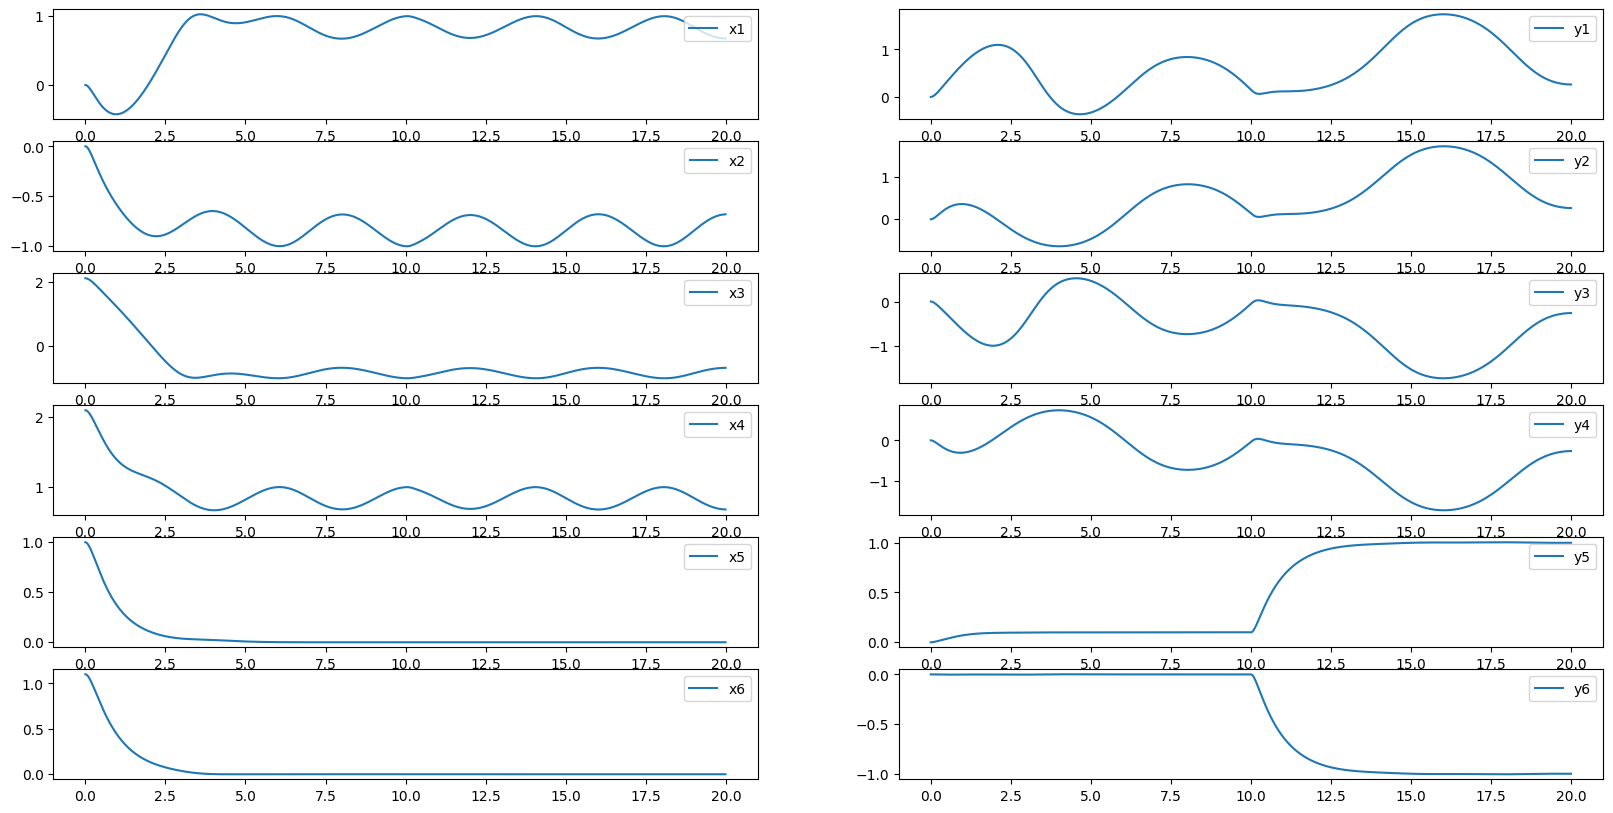

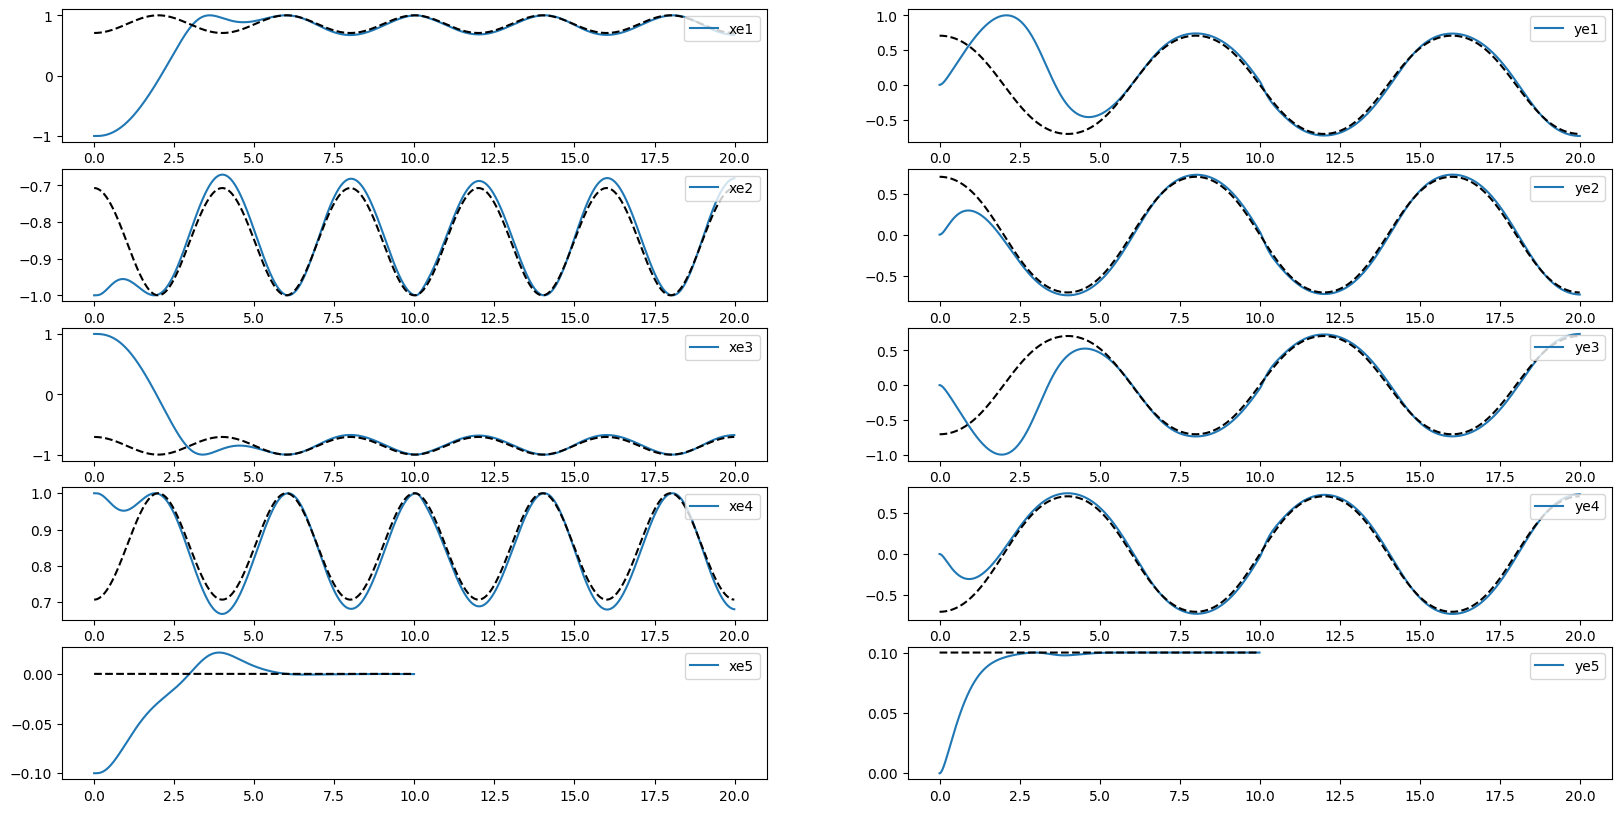

In [56]:
# Nodes
plt.figure(figsize=(20, 10))
for i in range(n):
    plt.subplot(n, 2, 2*i+1)
    plt.plot(t, Q[i, 0], label='x'+str(i+1))
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

    plt.subplot(n, 2, 2*i+2)
    plt.plot(t, Q[i, 1], label='y'+str(i+1))
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

# plt.plot(t, np.zeros(len(t)), color='black', linestyle='--')

# Edges
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.plot(t, Qe[i, 0, :], label='xe'+str(i+1))
    plt.plot(t, [(Qed(ti, k(ti))[i, 0] if i < k(ti) else np.nan) for ti in t], color='black', linestyle='--')
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

    plt.subplot(5, 2, 2*i+2)
    plt.plot(t, Qe[i, 1, :], label='ye'+str(i+1))
    plt.plot(t, [(Qed(ti, k(ti))[i, 1] if i < k(ti) else np.nan) for ti in t], color='black', linestyle='--')
    plt.legend(loc='upper right')
    plt.gca().set_xlim(-0.05*tf, tf + 0.05*tf)

# # Theta
# plt.figure()
# plt.plot(t, ((q1x-q2x)*(q2x-q3x)+(q1y-q2y)*(q2y-q3y))/(l1*l2), label=r'$\cos\theta$')
# #plt.axhline(Qed_val[0, :].dot(Qed_val[1, :])/(l1*l2), color='black', linestyle='--', label=r'$\cos\theta_{d}$')
# plt.title(r'$\cos\theta$')
# plt.legend()
# #plt.gca().set_ylim(-1.01, -0.99)

# # Forces
# plt.figure()
# plt.plot(t, np.linalg.norm(np.array([f1x, f1y]), axis=0))
# plt.plot(t, np.linalg.norm(np.array([f2x, f2y]), axis=0))
# plt.plot(t, np.linalg.norm(np.array([f3x, f3y]), axis=0))
# plt.title('Forces')
# #plt.legend()
# #plt.gca().set_ylim(-10, 10)

In [57]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2), aspect='equal')
ax.grid()

# Plot initial position
bars = []
for i in range(k(0)):
    d_i = D_of_G(k(0))[:, i]
    start_idx = np.where(d_i == 1)[0][0]
    end_idx = np.where(d_i == -1)[0][0]
    bar = ax.plot([Q_0[start_idx, 0], Q_0[end_idx, 0]], [Q_0[start_idx, 1], Q_0[end_idx, 1]], 'o-', lw=2)[0]
    bars.append(bar)

# Text box for time and torque
# text = ax.text(0.05, 0.9, f'time: {t[0]:.1f} s\ntau: {tau[0]:.1f} Nm', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=18)

fps = 30
def animate(i):
    idx = int(i/(fps*dt))
    ti = t[idx]
    for i in range(k(ti)):
        d_i = D_of_G(k(ti))[:, i]
        start_idx = np.where(d_i == 1)[0][0]
        end_idx = np.where(d_i == -1)[0][0]
        bars[i].set_data([Q[start_idx, 0, idx], Q[end_idx, 0, idx]], [Q[start_idx, 1, idx], Q[end_idx, 1, idx]])
    if k(ti) == 4:
        bars[4].set_data([], [])

tf_sim = tf
ani = animation.FuncAnimation(fig, animate, frames=fps*tf_sim)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'X-wing.mp4', writer=ffmpeg_writer)
plt.close(fig)